# Using graphSAGE to analyze movie networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparation, load packages and dataset

In [ ]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
def tokenizer_spacy(text, lemma=False):
    doc = nlp(text)
    article = []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_punct and not w.like_num:
            if lemma:
              # we add the lematized version of the word
              article.append(w.lemma_)
            else:
              article.append(w.text)
    return article

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 14.5 MB/s 
     |████████████████████████████████| 482 kB 67.6 MB/s 
     |████████████████████████████████| 462 kB 93.7 MB/s 
     |████████████████████████████████| 41 kB 634 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
from stellargraph import StellarGraph
from stellargraph import StellarDiGraph

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

In [ ]:
!pip install -q convokit 
from convokit import Corpus, download

corpus = Corpus(filename=download("movie-corpus"))
corpus.print_summary_stats()

     |████████████████████████████████| 167 kB 14.5 MB/s 
     |████████████████████████████████| 6.2 MB 80.2 MB/s 
     |████████████████████████████████| 1.5 MB 60.2 MB/s 
     |████████████████████████████████| 235 kB 54.4 MB/s 
     |████████████████████████████████| 175 kB 85.6 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 749 kB 78.0 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 181 kB 73.1 MB/s 
     |████████████████████████████████| 10.1 MB 53.7 MB/s 
     |████████████████████████████████| 660 kB 64.1 MB/s 
     |████████████████████████████████| 457 kB 61.2 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [ ]:
speaker_df = corpus.get_speakers_dataframe()
conv_df = corpus.get_conversations_dataframe()
utt_df = corpus.get_utterances_dataframe()

In [ ]:
speaker_df.head()

,vectors,meta.character_name,meta.movie_idx,meta.movie_name,meta.gender,meta.credit_pos
id,,,,,,
u0,[],BIANCA,m0,10 things i hate about you,f,4
u2,[],CAMERON,m0,10 things i hate about you,m,3
u3,[],CHASTITY,m0,10 things i hate about you,?,?
u4,[],JOEY,m0,10 things i hate about you,m,6
u5,[],KAT,m0,10 things i hate about you,f,2


In [ ]:
conv_df.head()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L984,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L924,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L870,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L866,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"


## Get StellarGraph Objects

We user the vector representation of lines of characters as node features. We user word2vec model trained using google news to get the vector representation. Then, we label movies with labels of being perferred by male audience/female audience, (or whether passed hagen test or not). Finally, we use thse information along with reply to information to construct StellarGraph Objects for all the movies.    

### Use word2vec model to get vecvor representations 

In [ ]:
import gensim

In [ ]:
model_address = "/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/GoogleNews-vectors-negative300.bin" 

In [ ]:
import gensim.models.keyedvectors as word2vec
google_model = word2vec.KeyedVectors.load_word2vec_format(model_address, binary=True)

In [ ]:
def get_avg_vect(example_df):
  '''get vector representation of of utterances'''
  vect_lst = [np.zeros(300)] * len(example_df)
  i = 0
  for _, row in tqdm(example_df.iterrows()):
    text = tokenizer_spacy(row['text'])
    vectors = []
    if len(text) > 0:
      for word in text:
          try:
              vectors.append(google_model.wv[word])
          except KeyError:
              pass
    if len(vectors) > 0:  
      avg_vect = np.mean(vectors, axis=0)
    else:
      avg_vect = np.zeros(300)
    vect_lst[i] = avg_vect
    i += 1
  return vect_lst 

In [ ]:
vect_lst = get_avg_vect(utt_df)
utt_df['vectors'] = vect_lst

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
304713it [45:25, 111.80it/s]


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/vect.npy', 
        np.array(list(utt_df['vectors'])))     

In [ ]:
utt_df['vectors'] = list(np.load('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/vect.npy'))

In [ ]:
np.array(list(utt_df['vectors'].values)).shape

(304713, 300)

### Get edges dataframe and node features dataframe

How to construct edges df and nodes df of one movie

In [ ]:
def get_movie_utt_dic(corpus):
    '''
    get the dictionary of movies that map movies to corresponding utterances. 
    In chronological order. 
    '''
    movie_utt_dic = {}
    movie_idx_name = {}
    for utt in tqdm(corpus.iter_utterances()):
        if utt.meta['movie_id'] not in movie_utt_dic:
            movie_utt_dic[utt.meta['movie_id']] = []
            movie_idx_name[utt.meta['movie_id']] = utt.speaker.meta['movie_name']
        movie_utt_dic[utt.meta['movie_id']].append(int(utt.id[1:]))
    
    for movie, utt_lst in tqdm(movie_utt_dic.items()):
        id_lst = sorted(utt_lst)
        movie_utt_dic[movie] =  ['L' + str(i) for i in id_lst]
    
    return movie_utt_dic, movie_idx_name
        
movie_utt_dic, movie_idx_name = get_movie_utt_dic(corpus)

304713it [00:00, 552564.23it/s]
100%|██████████| 617/617 [00:00<00:00, 5786.92it/s]


In [ ]:
def get_characters_from_one_movie(corpus, movie_utt_dic, movie_idx):
    '''
    get lines for characters.Using lemmatized lines when using models like word2vec. 
    '''
    characters = {}
    characters_attrs = {}
    
    for utt_id in movie_utt_dic[movie_idx]:
        utt = corpus.get_utterance(utt_id)
        speaker = utt.speaker
        if speaker.meta['movie_idx'] == movie_idx:
            if speaker.id not in characters:
                characters[speaker.id] = []
                characters_attrs[speaker.id] = {'character_name': speaker.meta['character_name'],
                                                'gender': speaker.meta['gender'],
                                                'credit_pos':speaker.meta['credit_pos']}
        
        characters[speaker.id].append(utt_id)
    return characters, characters_attrs

characters, characters_attrs = get_characters_from_one_movie(corpus, movie_utt_dic,'m180')

In [ ]:
def create_edges(corpus, utt_id_lst, characters):
    '''
    Using 'reply to' and the number of lines as weights to create egdes.
    undirected or Directed. 
    '''
    character_pairs = {}
    for utt_id in utt_id_lst:
        utt = corpus.get_utterance(utt_id)
        # speaker1 = utt.speaker.meta['character_name']
        speaker1_id = utt.speaker.id
        if speaker1_id in characters:
            if utt.reply_to is not None:
                # speaker2 = corpus.get_utterance(utt.reply_to).speaker.meta['character_name']
                speaker2_id = corpus.get_utterance(utt.reply_to).speaker.id
                if speaker2_id in characters and speaker2_id != speaker1_id:
                    if (speaker1_id, speaker2_id) not in character_pairs:          
                        character_pairs[(speaker1_id, speaker2_id)] = 0
                    character_pairs[(speaker1_id, speaker2_id)] += 1
    return character_pairs
                        
edges = create_edges(corpus, movie_utt_dic['m180'], characters)
edges

{('u2750', 'u2751'): 3,
 ('u2751', 'u2750'): 3,
 ('u2751', 'u2753'): 10,
 ('u2751', 'u2754'): 3,
 ('u2751', 'u2756'): 6,
 ('u2751', 'u2759'): 4,
 ('u2751', 'u2760'): 7,
 ('u2751', 'u2761'): 4,
 ('u2751', 'u2762'): 23,
 ('u2752', 'u2760'): 6,
 ('u2753', 'u2751'): 9,
 ('u2753', 'u2762'): 5,
 ('u2754', 'u2751'): 4,
 ('u2755', 'u2757'): 3,
 ('u2756', 'u2751'): 7,
 ('u2756', 'u2762'): 9,
 ('u2757', 'u2755'): 2,
 ('u2758', 'u2765'): 2,
 ('u2759', 'u2751'): 3,
 ('u2759', 'u2760'): 3,
 ('u2759', 'u2762'): 3,
 ('u2759', 'u2763'): 3,
 ('u2760', 'u2751'): 10,
 ('u2760', 'u2752'): 5,
 ('u2760', 'u2759'): 3,
 ('u2760', 'u2762'): 2,
 ('u2760', 'u2764'): 7,
 ('u2761', 'u2751'): 1,
 ('u2761', 'u2765'): 3,
 ('u2762', 'u2751'): 19,
 ('u2762', 'u2753'): 5,
 ('u2762', 'u2756'): 10,
 ('u2762', 'u2759'): 4,
 ('u2762', 'u2760'): 4,
 ('u2762', 'u2765'): 20,
 ('u2762', 'u2766'): 17,
 ('u2763', 'u2759'): 2,
 ('u2764', 'u2760'): 10,
 ('u2765', 'u2758'): 4,
 ('u2765', 'u2761'): 2,
 ('u2765', 'u2762'): 16,
 ('u276

#### edges df 

In [ ]:
def contruct_edges_df(edges):
  source = []
  target = []
  weights = []
  for k, v in edges.items():
    source.append(int(k[0][1:]))
    target.append(int(k[1][1:]))
    weights.append(v)
  return pd.DataFrame({'source':source,
                       'target':target,
                       'weight':weights})

In [ ]:
contruct_edges_df(edges)

,source,target,weight
0,2762,2751,19
1,2751,2762,23
2,2765,2762,16
3,2762,2765,20
4,2751,2754,3
5,2754,2751,4
6,2763,2759,2
7,2759,2763,3
8,2760,2759,3
9,2759,2760,3


#### nodes df

In [ ]:
len(characters)

12

In [ ]:
from sklearn.decomposition import PCA
def construct_nodes_df(characters, utt_df, speaker_df):
  characters_lst = []
  characters_vect = []
  for character, utts in characters.items():
    mean_vect = np.zeros(300)
    i = 0
    for utt in utts: 
      utt_vect = utt_df.loc[utt, 'vectors']
      if np.sum(utt_vect) != 0:
        mean_vect += utt_vect
        i += 1
    if i != 0:
      mean_vect = mean_vect/i 
    characters_vect.append(mean_vect)
    characters_lst.append(int(character[1:]))
  
  characters_vect = np.array(characters_vect)
  # print(characters_vect)
  # print(characters_vect.shape)
  pca = PCA(n_components=2)
  pca_embed = pca.fit_transform(characters_vect)

  characters_feature = {}
  for j in range(2):
    feature = 'dim_{}'.format(j)
    characters_feature[feature] = pca_embed[:, j]

  gender_other = []
  gender_male = []
  gender_female = []
  for character in characters.keys():
    if speaker_df.loc[character, 'meta.gender'].lower() == 'f':
      gender_other.append(0)
      gender_male.append(0)
      gender_female.append(1)
    elif speaker_df.loc[character, 'meta.gender'].lower() == 'm':
      gender_other.append(0)
      gender_male.append(1)
      gender_female.append(0)
    else:
      gender_other.append(1)
      gender_male.append(0)
      gender_female.append(0)
  characters_feature['gender_other'] = gender_other
  characters_feature['gender_male'] = gender_male
  characters_feature['gender_female'] = gender_female

  return pd.DataFrame(characters_feature, index=characters_lst)

In [ ]:
characters, characters_attrs = get_characters_from_one_movie(corpus, movie_utt_dic,'m0')
construct_nodes_df(characters, utt_df, speaker_df)

,dim_0,dim_1,gender_other,gender_male,gender_female
0,-0.088254,-0.049465,0,0,1
3,0.124865,0.534934,1,0,0
9,-0.104776,-0.056245,0,1,0
8,-0.141748,-0.090632,1,0,0
7,-0.128492,-0.050625,0,1,0
2,-0.124447,-0.038140,0,1,0
5,-0.089273,-0.024302,0,0,1
6,-0.112524,-0.100172,0,0,1
4,-0.117538,-0.080552,0,1,0
10,-0.054108,0.107958,1,0,0


### Load movie info dataset

In [ ]:
movie_info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/IMDB_infos.csv')
movie_info = movie_info[movie_info['Problem'] == 0.0]
movie_info = movie_info.reset_index(drop=True)
columns = ['index', 'year','Title_en',
           'IMDB_male', 'IMDB_female']
movie_info = movie_info.loc[:, columns]

### Get movie labels using audience preferences

In [ ]:
labels = []
for _, row in movie_info.iterrows():
  labels.append(int(row['IMDB_male'] >= row['IMDB_female']))

movie_info['label'] = labels
movie_info

,index,year,Title_en,IMDB_male,IMDB_female,position_label,movie_embedding,label
0,m0,1999,10 things i hate about you,7.0,7.8,1,"[0.009962083, -0.055199612, -0.01930365, -0.00...",0
1,m1,1992,1492: conquest of paradise,6.4,6.4,1,"[-0.008293524, -0.06452279, 0.004257749, 0.072...",1
2,m10,1997,affliction,6.9,6.7,1,"[-0.05389537, 0.043476056, -0.029524803, -0.04...",1
3,m100,1987,innerspace,6.8,6.9,-1,"[-0.042457983, -0.0089417165, -0.080722585, 0....",0
4,m101,1999,the insider,7.9,7.7,1,"[0.012396937, -0.004923899, -0.079236984, -0.0...",1
...,...,...,...,...,...,...,...,...
598,m95,2007,i am legend,7.2,7.2,1,"[0.081720255, -0.034610525, 0.1836845, -0.1735...",1
599,m96,1953,invaders from mars,6.2,6.4,-1,"[0.1130741, 0.07803887, -0.09578803, -0.098598...",0
600,m97,1996,independence day,7.0,7.1,1,"[-0.050658934, -0.052601684, -0.0068283733, 0....",0
601,m98,1989,indiana jones and the last crusade,8.3,8.1,-1,"[0.030020263, -0.067624904, -0.054421864, 0.03...",1


In [ ]:
from collections import Counter
Counter(movie_info['label'])

Counter({0: 305, 1: 298})

Balanced dataset! Here label 1 means male users give higher ratings.

### Get movie labels using Proportion of female characters

In [ ]:
male_utt = 0
female_utt = 0
for idx, row in tqdm(utt_df.iterrows()):
  if speaker_df.loc[row['speaker'], 'meta.gender'].lower() == 'f':
    female_utt += 1
  if speaker_df.loc[row['speaker'], 'meta.gender'].lower() == 'm':
    male_utt += 1
male_utt, female_utt, (male_utt + female_utt)/len(utt_df)

304713it [00:21, 14165.07it/s]


(170768, 71255, 0.794265423529682)

This means that support characters don't have gender information. We can look at movies that have more female characters.

In [ ]:
prop = []
for movie, utt_lst in tqdm(movie_utt_dic.items()):
  male = 0
  female = 0
  for utt in utt_lst:
    if speaker_df.loc[utt_df.loc[utt, 'speaker'], 'meta.gender'].lower() == 'f':
      female += 1
    if speaker_df.loc[utt_df.loc[utt, 'speaker'], 'meta.gender'].lower() == 'm':
      male += 1
  try: 
    prop.append((male)/(female + male))
  except ZeroDivisionError:
    prop.append(-1)

100%|██████████| 617/617 [00:10<00:00, 60.04it/s]


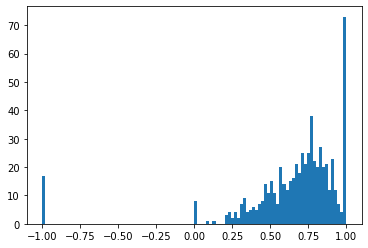

In [ ]:
plt.hist(prop, 100);

In [ ]:
male_dominant_movie = []
female_dominant_movie = []

movie_prop_dic = {}
for proportion, movie in zip(prop, movie_utt_dic.keys()):
  movie_prop_dic[movie] = proportion
  if proportion <= 0.5 and proportion >= 0:
    female_dominant_movie.append(movie)
  if proportion > 0.5 : 
    male_dominant_movie.append(movie)
len(male_dominant_movie), len(female_dominant_movie)

(499, 101)

In [ ]:
labels = []
for idx, row in movie_info.iterrows():
  if movie_prop_dic[row['index']] <= 0.5 and movie_prop_dic[row['index']] >= 0:
    labels.append(0)
  elif movie_prop_dic[row['index']] >= 0.9:
    labels.append(1)
  else:
    labels.append(-1)
movie_info['label_gender'] = labels

In [ ]:
Counter(movie_info['label_gender'])

Counter({-1: 387, 0: 98, 1: 118})

### Get moive labels using credit positions

In [ ]:
position_mask = (speaker_df['meta.credit_pos'] == str(1)) 
# & ((speaker_df['meta.gender'] == 'f')|(speaker_df['meta.gender'] == 'F'))
Counter(speaker_df[position_mask]['meta.gender'])

Counter({'f': 89, 'm': 408})

In [ ]:
movie_credit_pos_dic = {}
for idx, row in speaker_df[position_mask].iterrows():
  movie_credit_pos_dic[row['meta.movie_idx']] = row['meta.gender']

In [ ]:
labels = []
for idx, row in movie_info.iterrows():
  if row['index'] in movie_credit_pos_dic:
    if row['index'] == 'm':
      labels.append(0)
    else:
      labels.append(1)
  else:
    labels.append(-1)
movie_info['position_label'] = labels
movie_info

,index,year,Title_en,IMDB_male,IMDB_female,position_label,movie_embedding,label,label_gender
0,m0,1999,10 things i hate about you,7.0,7.8,1,"[0.009962083, -0.055199612, -0.01930365, -0.00...",0,-1
1,m1,1992,1492: conquest of paradise,6.4,6.4,1,"[-0.008293524, -0.06452279, 0.004257749, 0.072...",1,1
2,m10,1997,affliction,6.9,6.7,1,"[-0.05389537, 0.043476056, -0.029524803, -0.04...",1,-1
3,m100,1987,innerspace,6.8,6.9,-1,"[-0.042457983, -0.0089417165, -0.080722585, 0....",0,-1
4,m101,1999,the insider,7.9,7.7,1,"[0.012396937, -0.004923899, -0.079236984, -0.0...",1,1
...,...,...,...,...,...,...,...,...,...
598,m95,2007,i am legend,7.2,7.2,1,"[0.081720255, -0.034610525, 0.1836845, -0.1735...",1,-1
599,m96,1953,invaders from mars,6.2,6.4,-1,"[0.1130741, 0.07803887, -0.09578803, -0.098598...",0,-1
600,m97,1996,independence day,7.0,7.1,1,"[-0.050658934, -0.052601684, -0.0068283733, 0....",0,-1
601,m98,1989,indiana jones and the last crusade,8.3,8.1,-1,"[0.030020263, -0.067624904, -0.054421864, 0.03...",1,1


### Undirected StellarGraph

In [ ]:
node_data = construct_nodes_df(characters, utt_df, speaker_df)
edge_data = contruct_edges_df(edges)

In [ ]:
G = StellarGraph(
    {"characters": node_data}, {"line": edge_data}
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 17, Edges: 44

 Node types:
  characters: [17]
    Features: float32 vector, length 6
    Edge types: characters-line->characters

 Edge types:
    characters-line->characters: [44]
        Weights: range=[1, 23], mean=6.56818, std=5.57569
        Features: none


### Directed StellarGraph

In [ ]:
G = StellarDiGraph(
    {"characters": node_data}, {"line": edge_data}
)
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 17, Edges: 44

 Node types:
  characters: [17]
    Features: float32 vector, length 6
    Edge types: characters-line->characters

 Edge types:
    characters-line->characters: [44]
        Weights: range=[1, 23], mean=6.56818, std=5.57569
        Features: none


## Train and get embeddings of graphs

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from stellargraph.mapper import GraphSAGENodeGenerator
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def train_one_graph_get_embed(G, node_data):
  nodes = list(G.nodes())
  number_of_walks = 1
  length = 2

  unsupervised_samples = UnsupervisedSampler(
      G, nodes=nodes, length=length, number_of_walks=number_of_walks
  )

  batch_size = 2
  epochs = 20
  num_samples = [4, 2]

  generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
  train_gen = generator.flow(unsupervised_samples)

  layer_sizes = [50, 50]
  graphsage = GraphSAGE(
      layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
  )

  # Build the model and expose input and output sockets of graphsage, for node pair inputs:
  x_inp, x_out = graphsage.in_out_tensors()

  prediction = link_classification(
      output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
  )(x_out)  

  model = keras.Model(inputs=x_inp, outputs=prediction)
  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.binary_accuracy],
  )

  history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=0,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
  )

  x_inp_src = x_inp[0::2]
  x_out_src = x_out[0]
  embedding_model = keras.Model(inputs=x_inp_src, 
                                outputs=x_out_src)

  node_ids = node_data.index
  node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)
  node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)
  return node_ids, node_embeddings

In [ ]:
def get_embed_of_all_movies(movie_info, corpus, movie_utt_dic, utt_df, directed=False):
  embeddings = [np.zeros(50)] * len(movie_info)
  i = 0
  speaker_embeddings = {}
  for movie_id in tqdm(movie_info['index']):
    characters, _ = get_characters_from_one_movie(corpus, movie_utt_dic, movie_id)
    edges = create_edges(corpus, movie_utt_dic[movie_id], characters)
    edge_data = contruct_edges_df(edges)
    node_data = construct_nodes_df(characters, utt_df, speaker_df)
    if directed:
      G = StellarDiGraph({"characters": node_data}, {"line": edge_data})
    else:
      G = StellarGraph({"characters": node_data}, {"line": edge_data})
    node_ids, node_embeddings = train_one_graph_get_embed(G, node_data)
    embeddings[i] = np.mean(node_embeddings, axis=0)
    for node_id, node_embedding in zip(node_ids, node_embeddings):
      speaker_embeddings[node_id] = node_embedding
    i += 1
  return embeddings, speaker_embeddings

In [ ]:
embeddings, speaker_embeddings = get_embed_of_all_movies(movie_info, corpus, movie_utt_dic, utt_df, directed=True)

In [ ]:
movie_info['movie_embedding'] = embeddings
X = np.array(embeddings)

#### Vis with labels of preference

In [ ]:
transform = TSNE  # PCA
tsne_trans = transform(n_components=2)
tsne_transformed = pd.DataFrame(tsne_trans.fit_transform(X), index=movie_info.index)
tsne_transformed["label"] = movie_info['label']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


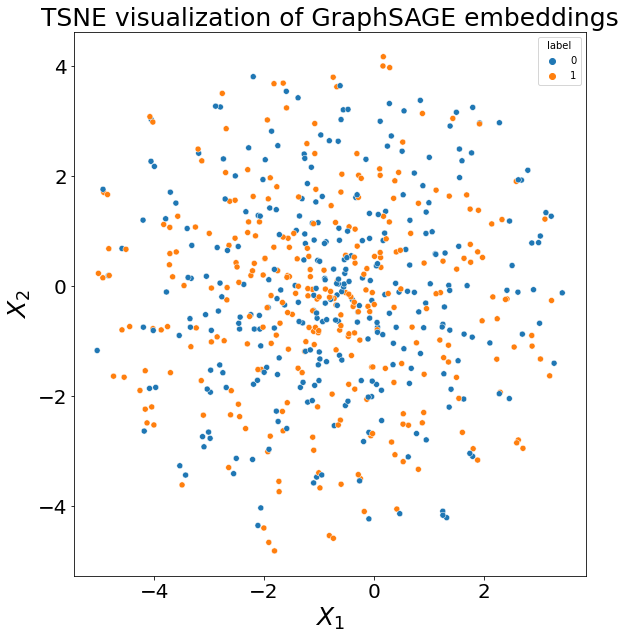

In [ ]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=tsne_transformed, x=0, y=1, hue="label")
ax.set(aspect="equal")
ax.set_ylabel("$X_2$", fontsize=25)
ax.set_xlabel("$X_1$", fontsize=25)
ax.tick_params(labelsize=20)
plt.title(
    "{} visualization of GraphSAGE embeddings".format(transform.__name__),
    fontsize=25
    )
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/20epoch_tsne_5_feature.jpg')

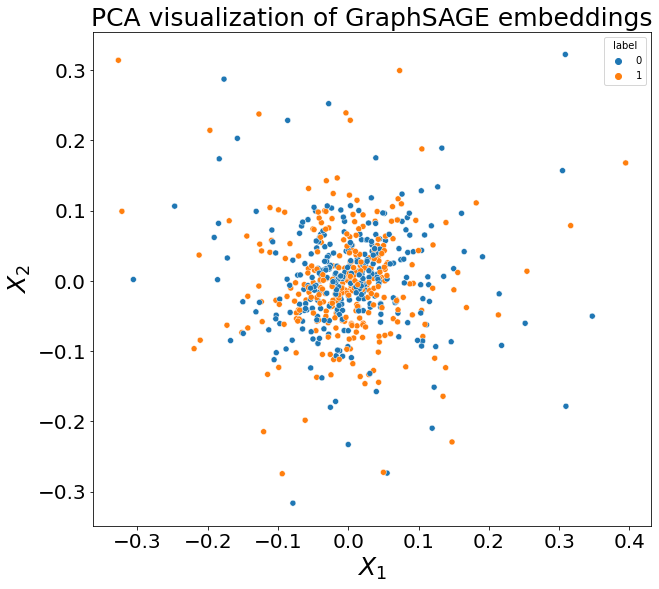

In [ ]:
pca = PCA(n_components=2)
pca_embed = pca.fit_transform(X)
pca_transformed = pd.DataFrame(pca_embed, index=movie_info.index)
pca_transformed["label"] = movie_info['label']

alpha = 0.7
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=pca_transformed, x=0, y=1, hue="label")
ax.set(aspect="equal")
ax.set_ylabel("$X_2$", fontsize=25)
ax.set_xlabel("$X_1$", fontsize=25)
ax.tick_params(labelsize=20)
plt.title(
    "PCA visualization of GraphSAGE embeddings",
    fontsize=25
    )
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/20epoch_pca_5_feature.jpg')

#### Vis with labels generated using proportion of female characters. 

In [ ]:
mask = movie_info['label_gender'] != -1
embeddings_masked, labels_masked = movie_info[mask].movie_embedding, movie_info[mask].label_gender 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state=42)
# Resample X and y so there are equal numbers of each y
embeddings_sampled, labels_sampled = resampler.fit_resample(list(embeddings_masked), labels_masked.values)
pd.Series(labels_sampled).value_counts()

0    98
1    98
dtype: int64

In [ ]:
X_sampled = np.array(embeddings_sampled)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


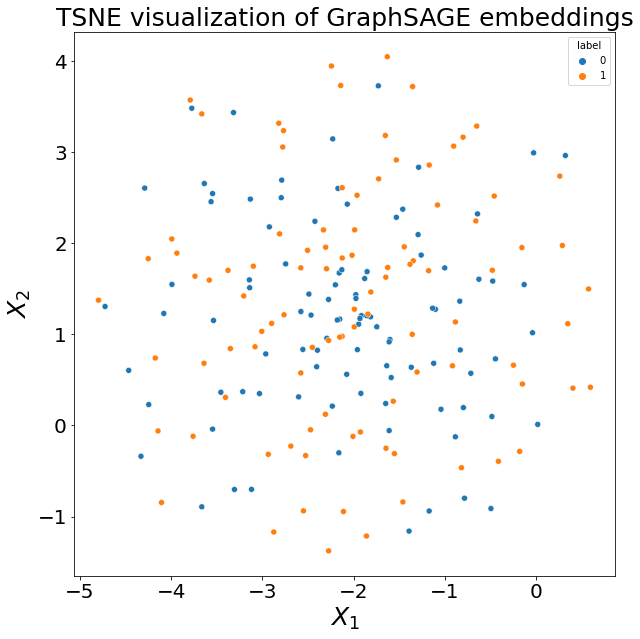

In [ ]:
transform = TSNE  # PCA
tsne_trans = transform(n_components=2)
tsne_transformed = pd.DataFrame(tsne_trans.fit_transform(X_sampled))
tsne_transformed["label"] = labels_sampled

alpha = 0.7
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=tsne_transformed, x=0, y=1, hue="label")
ax.set(aspect="equal")
ax.set_ylabel("$X_2$", fontsize=25)
ax.set_xlabel("$X_1$", fontsize=25)
ax.tick_params(labelsize=20)
plt.title(
    "{} visualization of GraphSAGE embeddings".format(transform.__name__),
    fontsize=25
    )
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/20epoch_tsne_5_feature_sampled.jpg')

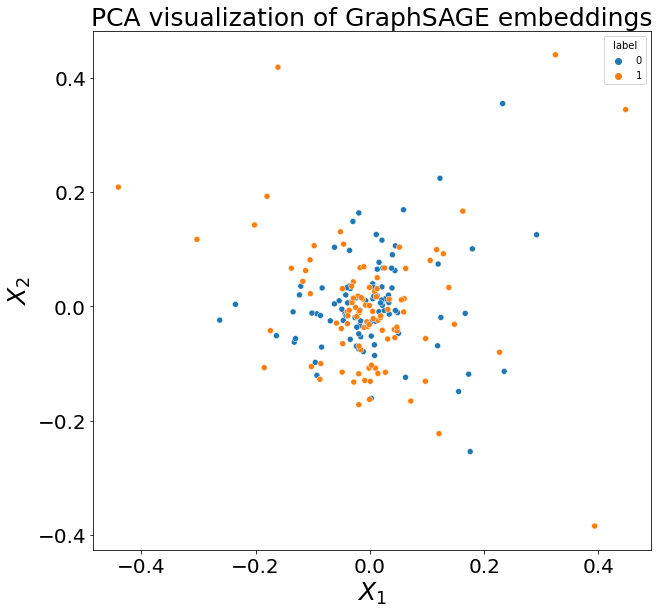

In [ ]:
pca = PCA(n_components=2)
pca_embed = pca.fit_transform(X_sampled)
pca_transformed = pd.DataFrame(pca_embed)
pca_transformed["label"] = labels_sampled

alpha = 0.7
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=pca_transformed, x=0, y=1, hue="label")
ax.set(aspect="equal")
ax.set_ylabel("$X_2$", fontsize=25)
ax.set_xlabel("$X_1$", fontsize=25)
ax.tick_params(labelsize=20)
plt.title(
    "PCA visualization of GraphSAGE embeddings",
    fontsize=25
    )
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/20_epoch_pca_5_feature_sampled.jpg')

#### Speaker embeddings(Not used)


Just an experiment. 

In [ ]:
movie_set = set(speaker_df[position_mask]['meta.movie_idx'])
movie_info_set = set(movie_info['index'])

In [ ]:
main_character_embeddings = {}
movie_first_character_gender = {}
for idx, row in speaker_df[position_mask].iterrows():
  if row['meta.movie_idx'] in movie_info_set: 
    id = int(idx[1:])
    main_character_embeddings[row['meta.movie_idx']] = speaker_embeddings[id]
    movie_first_character_gender[row['meta.movie_idx']] = row['meta.gender']

charahcter_embedding_for_movies = []
has_first_credit_pos = []
main_characater_gender = []
for idx, row in movie_info.iterrows():
  if row['index'] in main_character_embeddings:
    has_first_credit_pos.append(1)
    charahcter_embedding_for_movies.append(main_character_embeddings[row['index']])
    main_characater_gender.append(movie_first_character_gender[row['index']])
    # 1 if movie_first_character_gender[row['index']] == 'm' else 0
  else:
    has_first_credit_pos.append(0)
    charahcter_embedding_for_movies.append(np.zeros(50))
    main_characater_gender.append(-1)    

In [ ]:
movie_info['first_credit_mark'] = has_first_credit_pos
movie_info['main_character_embedding'] = charahcter_embedding_for_movies
movie_info['main_character_gender'] = main_characater_gender

In [ ]:
Counter(movie_info['main_character_gender'])

Counter({-1: 130, 'f': 85, 'm': 388})

In [ ]:
main_character_mask = movie_info['first_credit_mark'] == 1 
movie_info[main_character_mask]

,index,year,Title_en,IMDB_male,IMDB_female,position_label,movie_embedding,label,label_gender,first_credit_mark,main_character_embedding,main_character_gender
0,m0,1999,10 things i hate about you,7.0,7.8,1,"[0.009962083, -0.055199612, -0.01930365, -0.00...",0,-1,1,"[-0.11156259, 0.012885341, -0.0058568493, 0.17...",m
1,m1,1992,1492: conquest of paradise,6.4,6.4,1,"[-0.008293524, -0.06452279, 0.004257749, 0.072...",1,1,1,"[0.12317541, -0.051431525, 0.003784584, 0.0170...",m
2,m10,1997,affliction,6.9,6.7,1,"[-0.05389537, 0.043476056, -0.029524803, -0.04...",1,-1,1,"[-0.06169153, 0.042530563, -0.0855877, -0.0843...",m
4,m101,1999,the insider,7.9,7.7,1,"[0.012396937, -0.004923899, -0.079236984, -0.0...",1,1,1,"[0.08676165, 0.0017503015, -0.14422365, -0.036...",m
5,m102,2003,intolerable cruelty,6.3,6.0,1,"[0.0058223447, -0.013663935, -0.031213172, 0.0...",1,-1,1,"[0.092380755, -0.11801125, -0.1966998, 0.04949...",m
...,...,...,...,...,...,...,...,...,...,...,...,...
596,m93,2001,human nature,6.4,6.5,1,"[0.094785675, 0.0906445, -0.0077342913, -0.100...",0,-1,1,"[0.21838558, 0.22025363, 0.047680967, -0.20698...",f
597,m94,1961,the hustler,8.0,7.8,1,"[0.04823716, -0.10760154, 0.007122618, -0.0269...",1,-1,1,"[0.07507885, -0.255215, 0.12716782, 0.04593446...",m
598,m95,2007,i am legend,7.2,7.2,1,"[0.081720255, -0.034610525, 0.1836845, -0.1735...",1,-1,1,"[0.046508588, -0.094406255, 0.054354586, -0.17...",m
600,m97,1996,independence day,7.0,7.1,1,"[-0.050658934, -0.052601684, -0.0068283733, 0....",0,-1,1,"[-0.056801885, -0.16767612, -0.058877807, 0.10...",m


In [ ]:
embeddings_masked, labels_masked = movie_info[main_character_mask].main_character_embedding, movie_info[main_character_mask].main_character_gender 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state=42)
# Resample X and y so there are equal numbers of each y
embeddings_sampled, labels_sampled = resampler.fit_resample(list(embeddings_masked), labels_masked.values)
pd.Series(labels_sampled).value_counts()

f    85
m    85
dtype: int64

In [ ]:
X_sampled = np.array(embeddings_sampled)

In [ ]:
len(X_sampled)

170

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


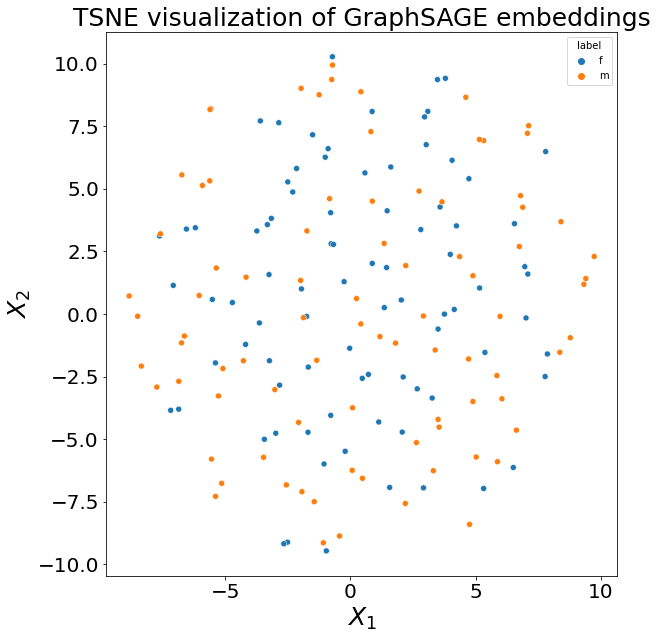

In [ ]:
transform = TSNE  # PCA
tsne_trans = transform(n_components=2)
tsne_transformed = pd.DataFrame(tsne_trans.fit_transform(X_sampled))
tsne_transformed["label"] = labels_sampled

alpha = 0.7
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=tsne_transformed, x=0, y=1, hue="label")
ax.set(aspect="equal")
ax.set_ylabel("$X_2$", fontsize=25)
ax.set_xlabel("$X_1$", fontsize=25)
ax.tick_params(labelsize=20)
plt.title(
    "{} visualization of GraphSAGE embeddings".format(transform.__name__),
    fontsize=25
    )
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/20epoch_tsne_5_feature_sampled_main_character.jpg')

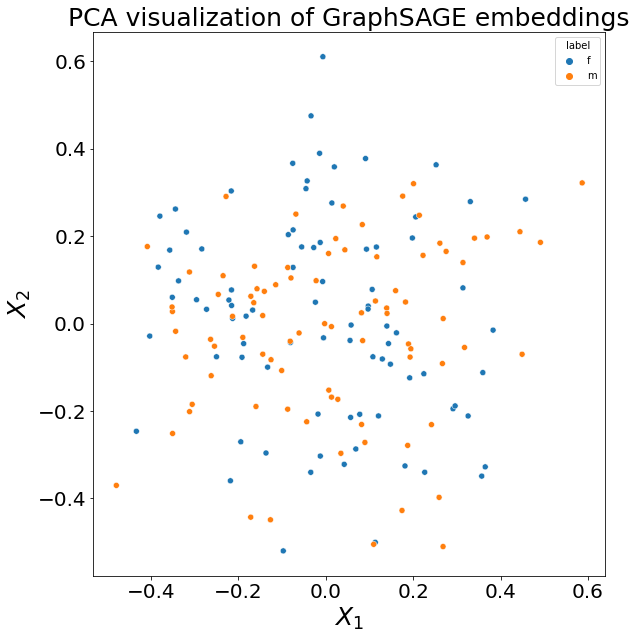

In [ ]:
pca = PCA(n_components=2)
pca_embed = pca.fit_transform(X_sampled)
pca_transformed = pd.DataFrame(pca_embed)
pca_transformed["label"] = labels_sampled

alpha = 0.7
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.scatterplot(data=pca_transformed, x=0, y=1, hue="label")
ax.set(aspect="equal")
ax.set_ylabel("$X_2$", fontsize=25)
ax.set_xlabel("$X_1$", fontsize=25)
ax.tick_params(labelsize=20)
plt.title(
    "PCA visualization of GraphSAGE embeddings",
    fontsize=25
    )
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/20_epoch_pca_5_feature_sampled_main_character.jpg')